In [1]:
# ==================================================================================================
# FAIRNESS FACTORIAL SIMULATION
# --------------------------------------------------------------------------------------------------
# Study: Artificial Intelligence from the Lens of Fairness
# This script implements the full factorial simulation design used in the paper.
#   • Models: Logistic Regression, Decision Tree
#   • Access Levels: Full / None
#   • Interventions: None / Postprocess (Equalized Odds)
#   • Replications: 10
#   • Metrics: Accuracy, SPD (Statistical Parity Difference), EOD (Equalized Odds Difference)
# --------------------------------------------------------------------------------------------------
# Other intervention functions (e.g., reweighting, residualization) are defined for completeness and initial inspection,
# though only "none" and "postprocess_eod" were used in the final paper.
# ==================================================================================================

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier


# ==============================================================================================
# 1. DATA GENERATION PROCESSES (F1–F3)
# ----------------------------------------------------------------------------------------------
# Each function defines a synthetic mechanism to introduce specific bias structures:
#   F1 – Structural Linear Bias
#   F2 – Nonlinear Bias
#   F3 – Asymmetric Label Noise
# ==============================================================================================

def gen_F1_structural_linear(n=5000, d=5, mu_gap=1.0, gamma=0.6, seed=0):
    """F1: Structural bias through a linear shift"""
    rng = np.random.default_rng(seed)
    A = rng.binomial(1, 0.5, size=n)
    X = rng.normal(0, 1, size=(n, d))
    e1 = np.zeros(d); e1[0] = 1.0
    mu0 = np.zeros(d); mu1 = mu0 + mu_gap * e1
    X += (A[:, None] * mu1 + (1 - A)[:, None] * mu0)
    eps = rng.normal(0, 1, size=n)
    z = X @ e1 + gamma * A + eps
    y = (z > 0).astype(int)
    return X, y, A


def gen_F2_nonlinear_proxy(n=5000, seed=0, a_scale=1.0, proxy_noise=0.5):
    """F2: Nonlinear bias."""
    rng = np.random.default_rng(seed)
    A = rng.binomial(1, 0.5, size=n)
    U = rng.normal(0, 1, size=n)
    X1 = rng.normal(1.5*a_scale*A + 0.5*U, 1.0, size=n)
    X2 = np.sin(X1) + 0.3*a_scale*A + rng.normal(0, 1, size=n)
    X3 = np.log(np.abs(X1)+1.0)*(2*A-1)*a_scale + 0.2*U + rng.normal(0, 1, size=n)
    proxy = 0.4*X1 - 0.2*X2 + 0.6*X3 + rng.normal(0, proxy_noise, size=n)
    z = 1.2*X1 - X2 + 0.8*X3 + 0.7*proxy + 0.9*a_scale*A + 0.5*U
    p = 1.0/(1.0 + np.exp(-z))
    y = (rng.random(size=n) < p).astype(int)
    X = np.column_stack([X1, X2, X3, proxy])
    return X, y, A


def gen_F3_label_noise_asym(n=5000, d=5, mu_gap=1.0, gamma=0.6, q0=0.05, q1=0.20, seed=0):
    """F3: Bias through asymmetric label noise differing by group."""
    X, y_clean, A = gen_F1_structural_linear(n, d, mu_gap, gamma, seed=seed)
    rng = np.random.default_rng(seed+1)
    flips = np.where(A==1, rng.random(n) < q1, rng.random(n) < q0)
    y_tilde = np.where(flips, 1 - y_clean, y_clean)
    return X, y_tilde, y_clean, A


# ==============================================================================================
# 2. SPLITTING & HELPER FUNCTIONS
# ==============================================================================================

def split_train_val_test(X, y, A, train=0.7, val=0.15, seed=0):
    """Randomly split data into train / validation / test sets."""
    n = len(y)
    rng = np.random.default_rng(seed)
    idx = rng.permutation(n)
    n_tr = int(train*n); n_va = int(val*n)
    tr = idx[:n_tr]; va = idx[n_tr:n_tr+n_va]; te = idx[n_tr+n_va:]
    return X[tr], y[tr], A[tr], X[va], y[va], A[va], X[te], y[te], A[te]


def flip_binary(A, p=0.3, seed=0):
    rng = np.random.default_rng(seed)
    flips = rng.random(size=A.shape) < p
    return np.where(flips, 1 - A, A)


# ==============================================================================================
# 3. INTERVENTIONS (Fairness Strategies)
# ----------------------------------------------------------------------------------------------
# Only 'none' and 'postprocess_eod' were applied in the paper.
# Reweighting and residualization are included for completeness.
# ==============================================================================================

def make_reweight(A):
    p1 = A.mean(); p0 = 1 - p1
    w = np.where(A==1, 1.0/max(p1,1e-9), 1.0/max(p0,1e-9))
    return w / w.mean()


def residualize_from_train(X_tr, A_tr, X_oth, A_oth):
    X_tr_res = np.zeros_like(X_tr)
    X_oth_res = np.zeros_like(X_oth)
    A_tr_ = A_tr.reshape(-1,1); A_oth_ = A_oth.reshape(-1,1)
    for j in range(X_tr.shape[1]):
        lr = LinearRegression().fit(A_tr_, X_tr[:,j])
        X_tr_res[:,j] = X_tr[:,j] - lr.predict(A_tr_)
        X_oth_res[:,j] = X_oth[:,j] - lr.predict(A_oth_)
    return X_tr_res, X_oth_res


def equalized_odds_thresholds(p_val, y_val, A_val, grid=101):
    ts = np.linspace(0,1,grid)
    best = (np.inf, 0.5, 0.5)
    for t0 in ts:
        for t1 in ts:
            yhat = np.where(A_val==1, (p_val>=t1).astype(int), (p_val>=t0).astype(int))
            def rates(g):
                m=(A_val==g); yt, yh = y_val[m], yhat[m]
                tp=((yt==1)&(yh==1)).sum(); fn=((yt==1)&(yh==0)).sum()
                fp=((yt==0)&(yh==1)).sum(); tn=((yt==0)&(yh==0)).sum()
                tpr = tp / max(tp+fn,1); fpr = fp / max(fp+tn,1)
                return tpr, fpr
            tpr0,fpr0 = rates(0); tpr1,fpr1 = rates(1)
            crit = max(abs(tpr0-tpr1), abs(fpr0-fpr1))
            if crit < best[0]:
                best = (crit, t0, t1)
    return {"t0": best[1], "t1": best[2]}


def apply_group_thresholds(p, A, th):
    """Apply group-specific thresholds learned from validation data."""
    return np.where(A==1, (p>=th["t1"]).astype(int), (p>=th["t0"]).astype(int))


# ==============================================================================================
# 4. METRICS
# ----------------------------------------------------------------------------------------------
# Computes accuracy, SPD, EOD, and per-group TPR/FPR.
# ==============================================================================================

def spd(yhat, A):
    """Absolute Statistical Parity Difference (0 = fair, higher = more unfair)."""
    return abs(yhat[A==1].mean() - yhat[A==0].mean())


def _tpr_fpr_by_group(y_true, y_pred, A):
    """Return TPR and FPR per group."""
    out = {}
    for g in (0, 1):
        m = (A == g)
        tp = np.sum((y_true[m] == 1) & (y_pred[m] == 1))
        fn = np.sum((y_true[m] == 1) & (y_pred[m] == 0))
        fp = np.sum((y_true[m] == 0) & (y_pred[m] == 1))
        tn = np.sum((y_true[m] == 0) & (y_pred[m] == 0))
        tpr = tp / max(tp + fn, 1)
        fpr = fp / max(fp + tn, 1)
        out[g] = (tpr, fpr)
    return out


def tpr_fpr_gaps(y_true, y_pred, A):
    """Return |TPR1−TPR0| and |FPR1−FPR0|."""
    rates = _tpr_fpr_by_group(y_true, y_pred, A)
    (tpr0, fpr0), (tpr1, fpr1) = rates[0], rates[1]
    return abs(tpr1 - tpr0), abs(fpr1 - fpr0)


def equalized_odds_gap(y_true, y_pred, A):
    """Return the maximum absolute difference between TPR/FPR across groups."""
    def rates(g):
        m = (A==g)
        tp = np.sum((y_true[m]==1)&(y_pred[m]==1))
        fn = np.sum((y_true[m]==1)&(y_pred[m]==0))
        fp = np.sum((y_true[m]==0)&(y_pred[m]==1))
        tn = np.sum((y_true[m]==0)&(y_pred[m]==0))
        tpr = tp / max(tp+fn, 1)
        fpr = fp / max(fp+tn, 1)
        return tpr, fpr
    tpr0, fpr0 = rates(0); tpr1, fpr1 = rates(1)
    return max(abs(tpr0-tpr1), abs(fpr0-fpr1))


# ==============================================================================================
# 5. MODEL FACTORY
# ==============================================================================================

def make_model(name, seed):
    """Return specified model instance."""
    name = name.lower()
    if name == "logistic":
        return LogisticRegression(max_iter=1000, solver="lbfgs", random_state=seed)
    if name == "tree":
        return DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=seed)
    raise ValueError("model ∈ {logistic, tree}")


# ==============================================================================================
# 6. SINGLE CONFIGURATION RUN
# ----------------------------------------------------------------------------------------------
# Runs one combination of (family × bias × access × intervention × model).
# ==============================================================================================

def run_config(family, bias, access, intervention, model, flip_p=0.3, seed=42):
    # --- Data generation per family
    if family == "linear":
        mu_gap = 1.0
        levels = {"low": 0.2, "med": 0.6, "high": 1.0}
        gamma = levels[bias]
        X, y, A = gen_F1_structural_linear(n=5000, d=5, mu_gap=mu_gap, gamma=gamma, seed=seed)
        X_tr,y_tr,A_tr, X_va,y_va,A_va, X_te,y_te,A_te = split_train_val_test(X,y,A, seed=seed)
        y_eval_te = y_te

    elif family == "nonlinear":
        proxy_noise = 0.5
        levels = {"low": 0.5, "med": 1.0, "high": 1.5}
        a_scale = levels[bias]
        X, y, A = gen_F2_nonlinear_proxy(n=5000, seed=seed, a_scale=a_scale, proxy_noise=proxy_noise)
        X_tr,y_tr,A_tr, X_va,y_va,A_va, X_te,y_te,A_te = split_train_val_test(X,y,A, seed=seed)
        y_eval_te = y_te

    elif family == "noisy outcome":
        mu_gap = 1.0
        levels = {
            "low":  (0.2, 0.05, 0.10),
            "med":  (0.6, 0.05, 0.20),
            "high": (1.0, 0.05, 0.35),
        }
        gamma, q0, q1 = levels[bias]
        X, y_tilde, y_clean, A = gen_F3_label_noise_asym(n=5000, d=5, mu_gap=mu_gap, gamma=gamma, q0=q0, q1=q1, seed=seed)
        X_tr,y_tr,A_tr, X_va,y_va,A_va, X_te,y_te,A_te = split_train_val_test(X,y_tilde,A, seed=seed)
        X_tr2,y_clean_tr,A_tr2, X_va2,y_clean_va,A_va2, X_te2,y_clean_te,A_te2 = split_train_val_test(X,y_clean,A, seed=seed)
        y_eval_te = y_clean_te

    else:
        raise ValueError("family ∈ {linear,nonlinear,noisy outcome}")

    # --- Access condition
    if access == "full":
        A_tr_use, A_va_use, A_te_use = A_tr, A_va, A_te
    elif access == "none":
        A_tr_use = A_va_use = A_te_use = None
    else:
        raise ValueError("access ∈ {full, none}")

    # --- Intervention handling
    sample_weight = None
    X_tr_use, X_va_use, X_te_use = X_tr.copy(), X_va.copy(), X_te.copy()

    if intervention not in {"none", "postprocess EOD"}:
        raise ValueError("intervention ∈ {none, postprocess EOD}")

    # --- Model fit
    clf = make_model(model, seed=seed)
    def with_A(X_, A_): return np.column_stack([X_, A_]) if A_ is not None else X_
    clf.fit(with_A(X_tr_use, A_tr_use), y_tr, sample_weight=sample_weight)
    p_va = clf.predict_proba(with_A(X_va_use, A_va_use))[:,1]
    p_te = clf.predict_proba(with_A(X_te_use, A_te_use))[:,1]

    # --- Postprocess (Equalized Odds)
    if (intervention == "postprocess EOD") and (A_va_use is not None):
        th = equalized_odds_thresholds(p_va, y_va, A_va_use, grid=101)
        yhat = apply_group_thresholds(p_te, A_te_use, th)
    else:
        yhat = (p_te >= 0.5).astype(int)

    # --- Compute metrics
    acc = (yhat == y_eval_te).mean()
    rates = _tpr_fpr_by_group(y_eval_te, yhat, A_te)
    (tpr0, fpr0), (tpr1, fpr1) = rates[0], rates[1]
    tpr_gap, fpr_gap = abs(tpr1 - tpr0), abs(fpr1 - fpr0)

    return {
        "accuracy": acc,
        "spd": spd(yhat, A_te),
        "eod": equalized_odds_gap(y_eval_te, yhat, A_te),
        "tpr0": tpr0, "fpr0": fpr0,
        "tpr1": tpr1, "fpr1": fpr1,
        "tpr_gap": tpr_gap, "fpr_gap": fpr_gap
    }


# ==============================================================================================
# 7. DRIVER FUNCTION (FULL FACTORIAL DESIGN)
# ==============================================================================================

def run_factorial_detailed(families, models, replicates=10, flip_p=0.3, seed0=123):
    """Run the full factorial experiment across families, biases, access levels, and models."""
    bias_levels = ["low","med","high"]
    access_levels = ["full","none"]
    interventions = ["none","postprocess EOD"]
    rows = []
    for fam in families:
        for bias in bias_levels:
            for access in access_levels:
                for intr in interventions:
                    for model in models:
                        for r in range(replicates):
                            seed = seed0 + 997*r
                            res = run_config(fam, bias, access, intr, model, flip_p=flip_p, seed=seed)
                            rows.append({
                                "family": fam, "bias": bias, "access": access,
                                "intervention": intr, "model": model,
                                "replicate": r, **res
                            })
    return pd.DataFrame(rows)


# ==============================================================================================
# 8. RUN EXPERIMENT AND SUMMARIZE RESULTS
# ==============================================================================================
FAMILIES = ["linear","nonlinear","noisy outcome"]
MODELS   = ["logistic","tree"]
REPLICATES = 10
FLIP_P = 0.3

df = run_factorial_detailed(FAMILIES, MODELS, replicates=REPLICATES, flip_p=FLIP_P, seed0=2024)
print(f"Completed {len(df)} aggregated configs.")

# --- Summary Statistics
summary = (
    df.groupby(["family","bias","access","intervention","model"])
      .agg(
          accuracy_mean=("accuracy","mean"), accuracy_std=("accuracy","std"),
          spd_mean=("spd","mean"),           spd_std=("spd","std"),
          eod_mean=("eod","mean"),           eod_std=("eod","std")
      )
      .reset_index()
)

display(summary.head())

Completed 720 aggregated configs.


,family,bias,access,intervention,model,accuracy_mean,accuracy_std,spd_mean,spd_std,eod_mean,eod_std
0,linear,high,full,none,logistic,0.829467,0.010432,0.474636,0.032545,0.609333,0.088710
1,linear,high,full,none,tree,0.828000,0.013828,0.449694,0.053598,0.574331,0.124993
2,linear,high,full,postprocess EOD,logistic,0.709467,0.017627,0.000000,0.000000,0.000000,0.000000
3,linear,high,full,postprocess EOD,tree,0.709467,0.017627,0.000000,0.000000,0.000000,0.000000
4,linear,high,none,none,logistic,0.811067,0.016878,0.283806,0.019447,0.168079,0.066854


/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


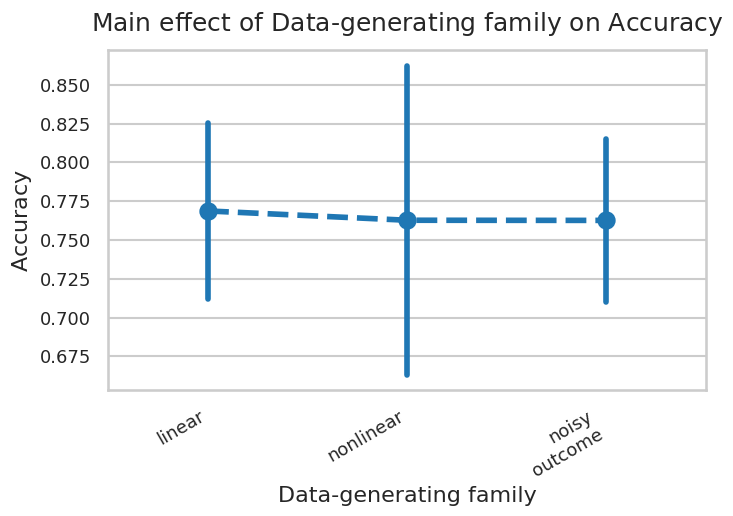

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


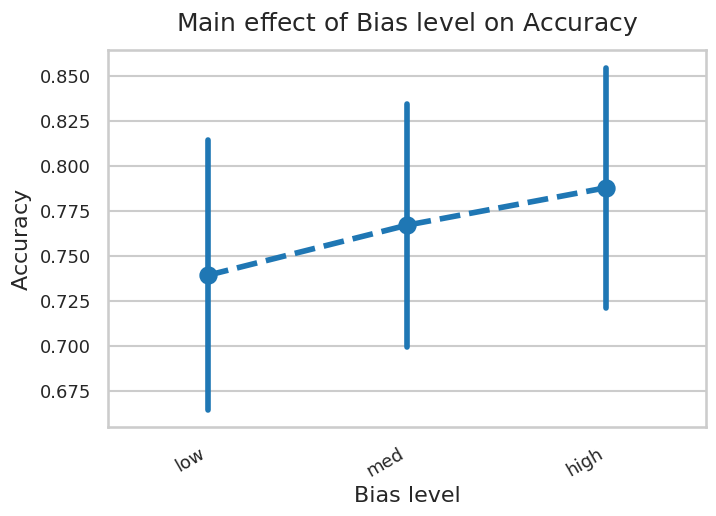

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


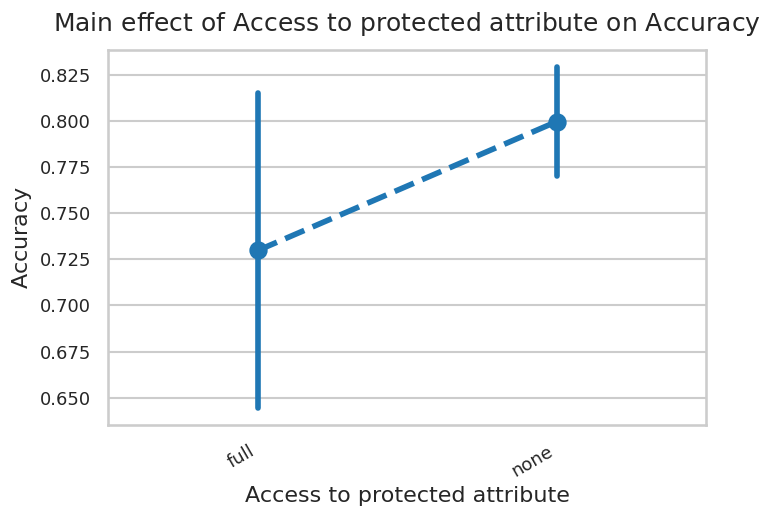

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


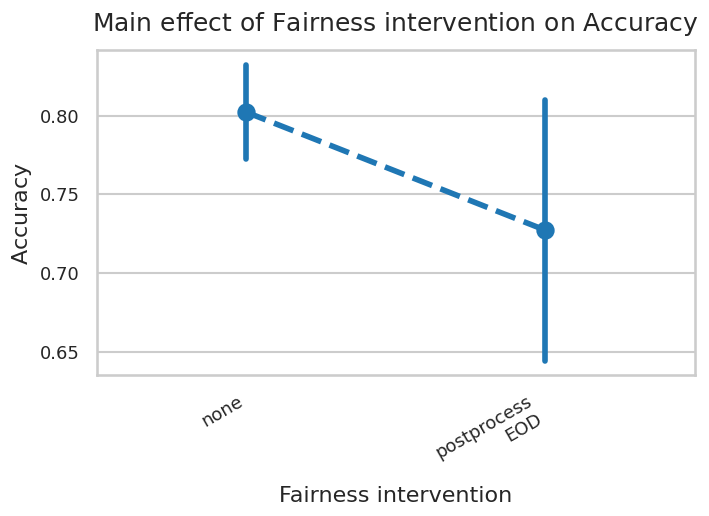

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


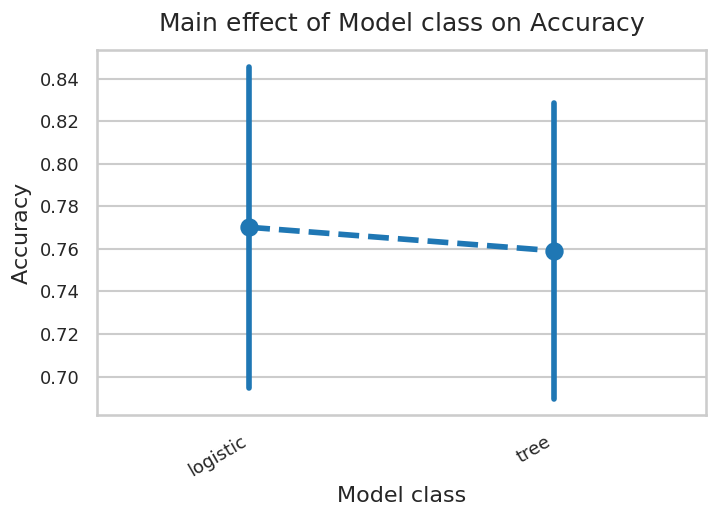

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


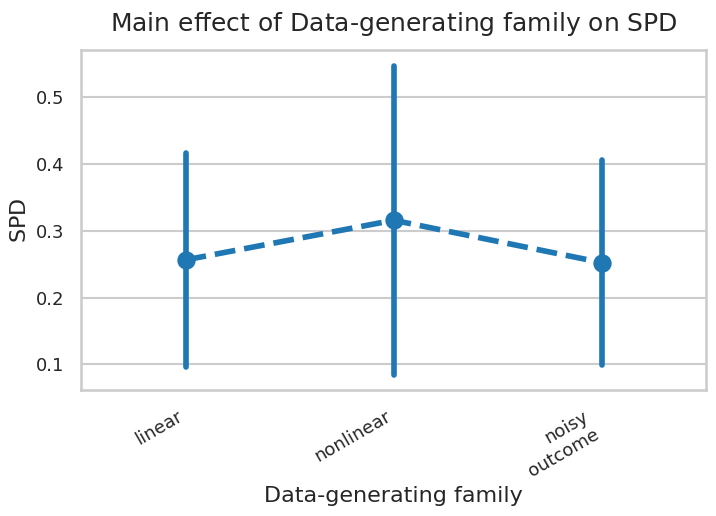

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


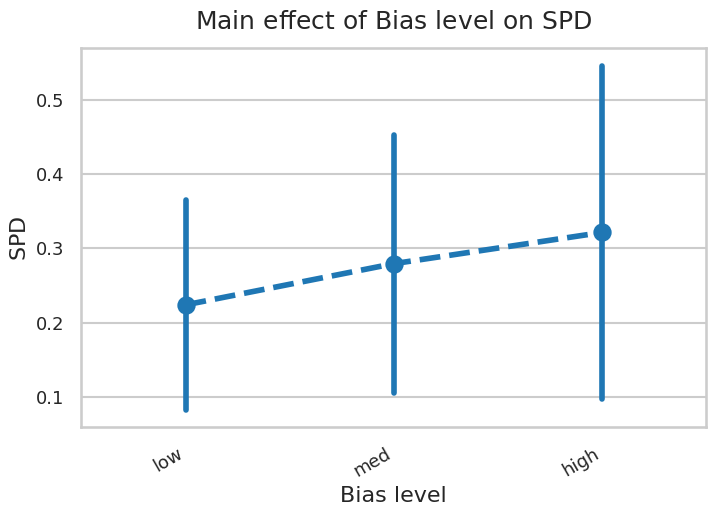

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


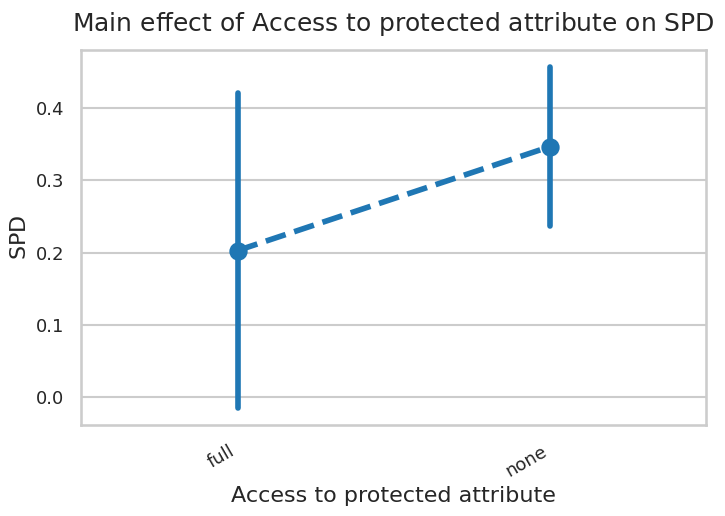

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


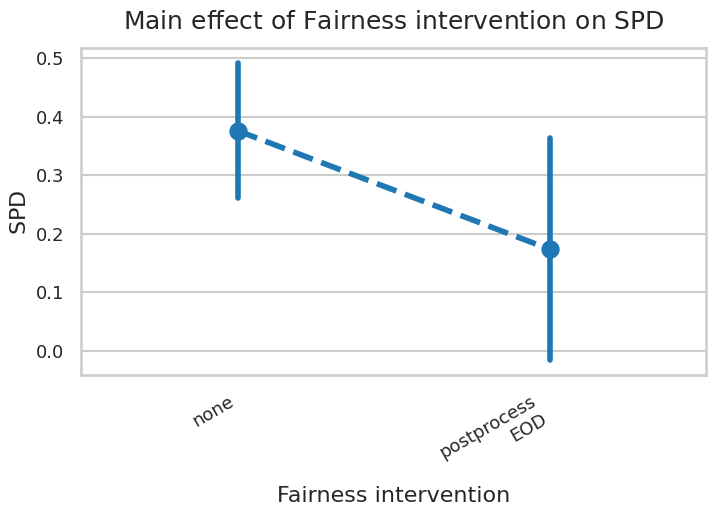

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


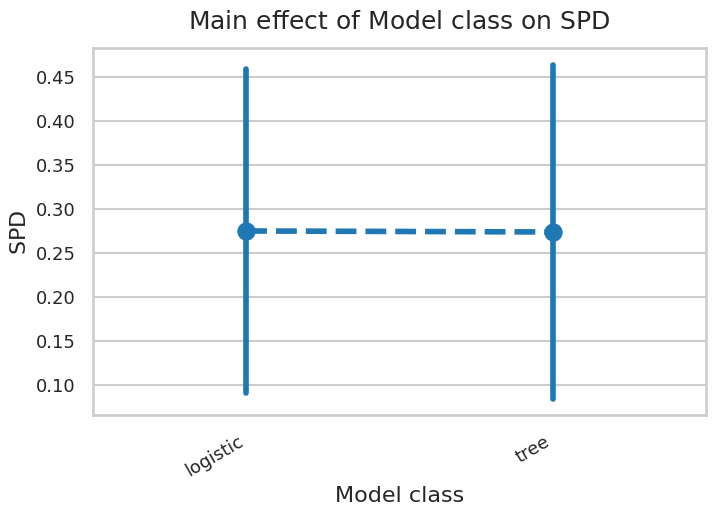

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


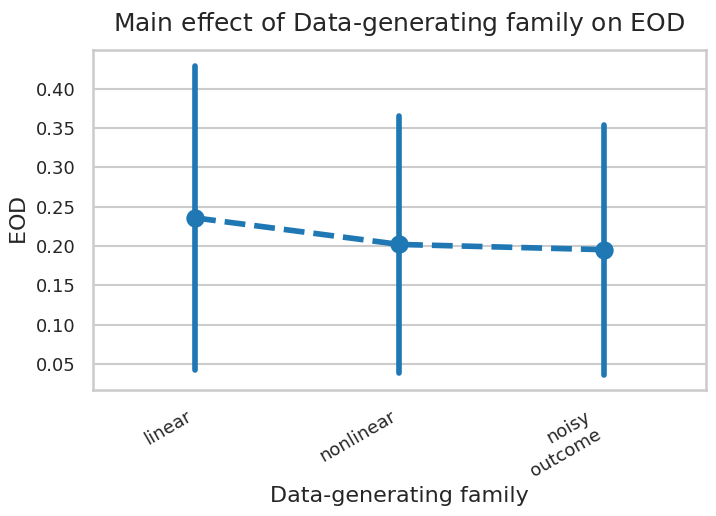

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


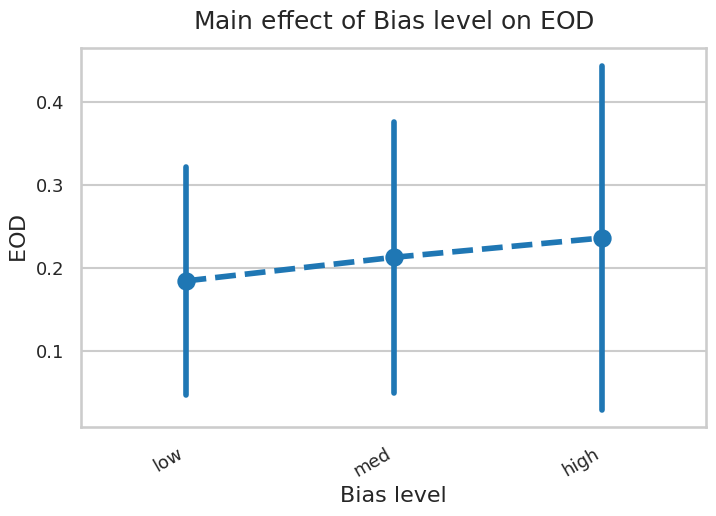

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


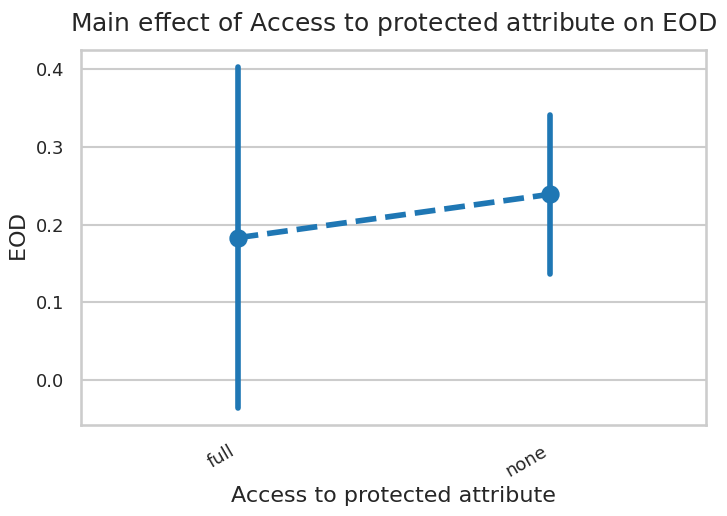

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


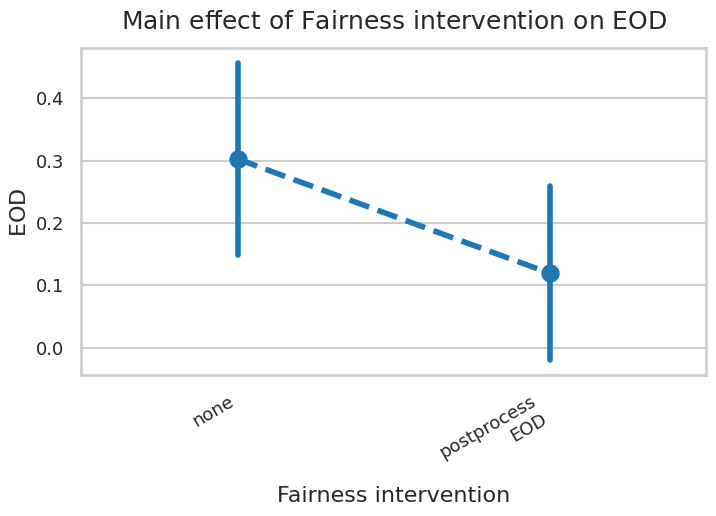

/tmp/ipython-input-4227386274.py:91: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


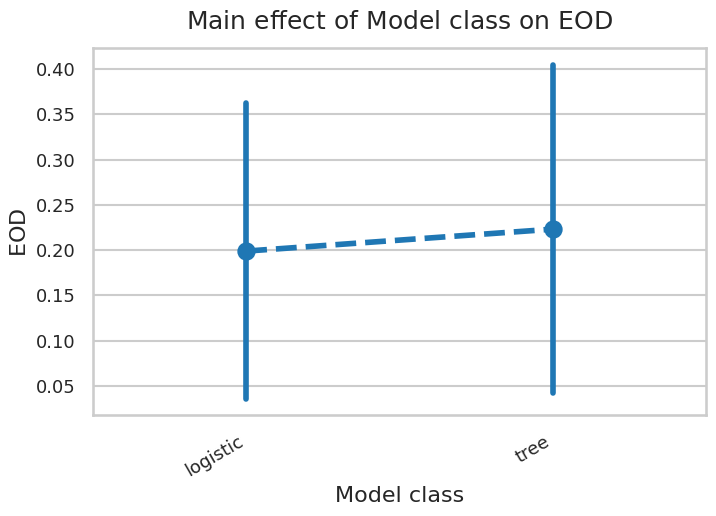

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


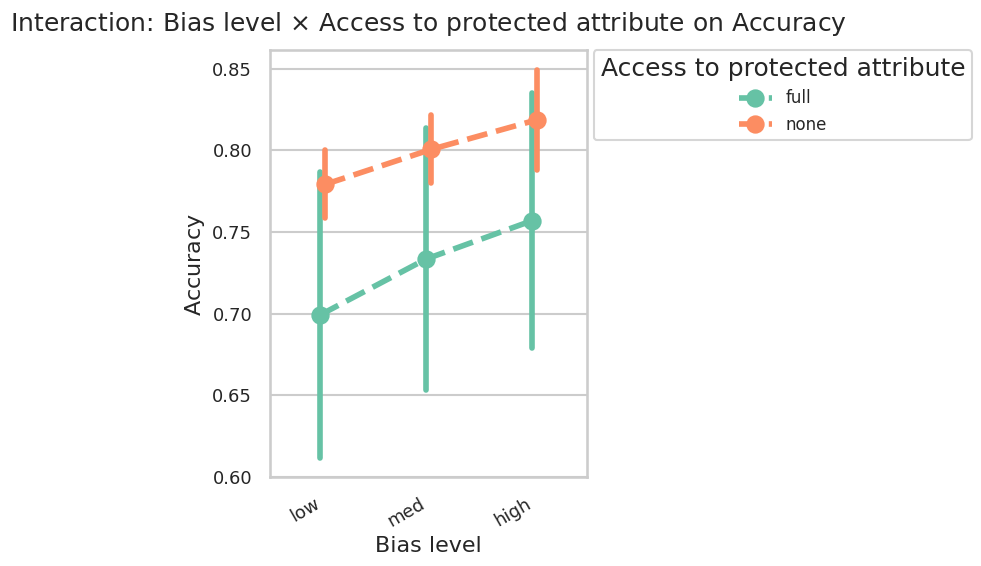

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


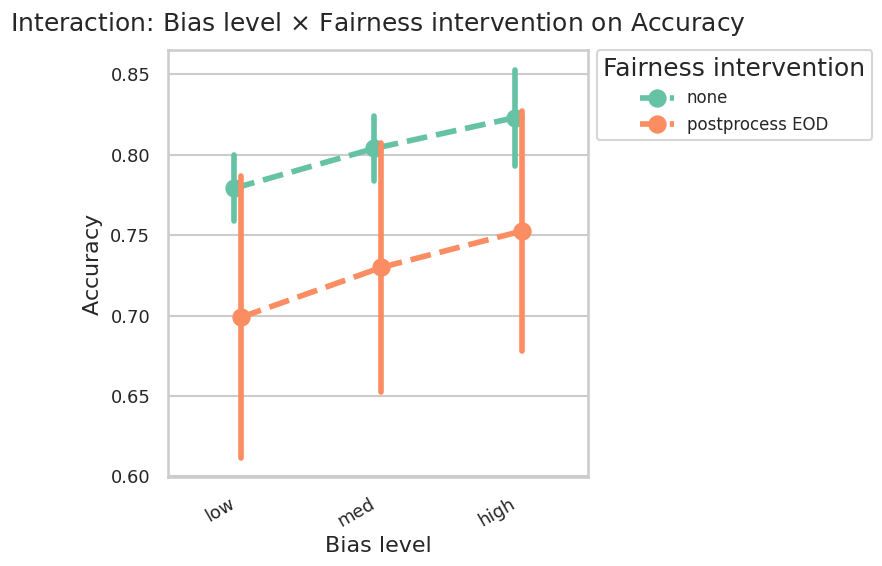

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


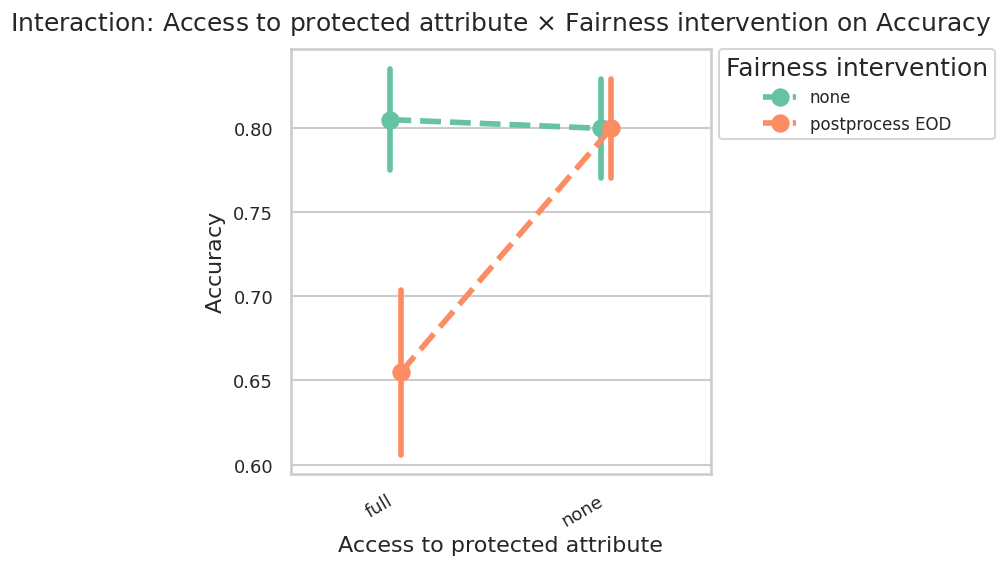

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


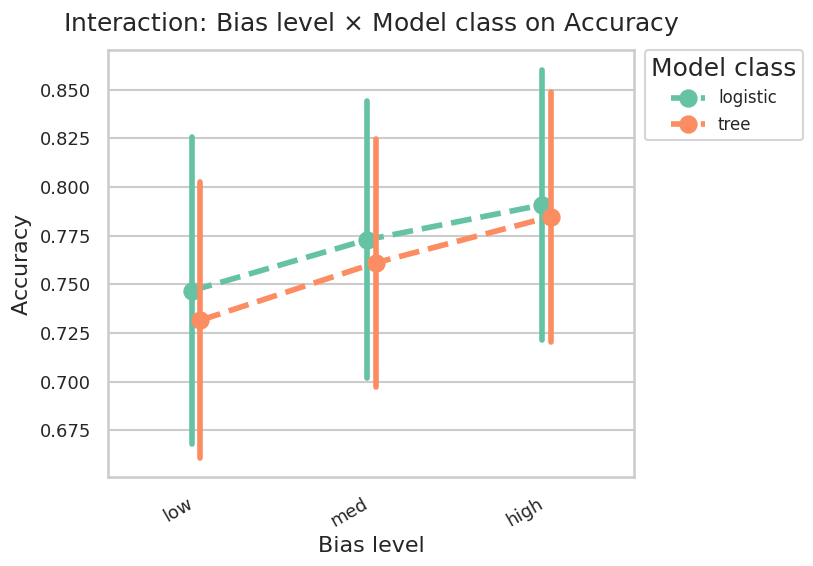

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


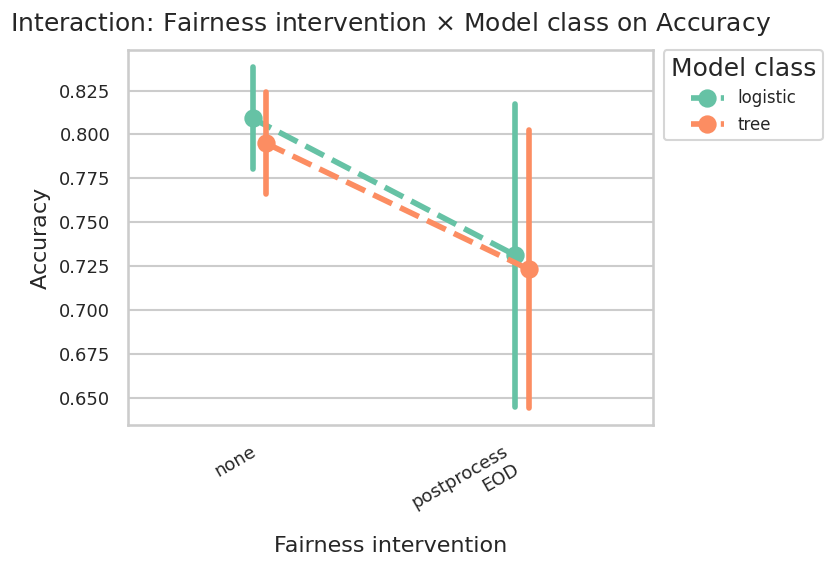

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


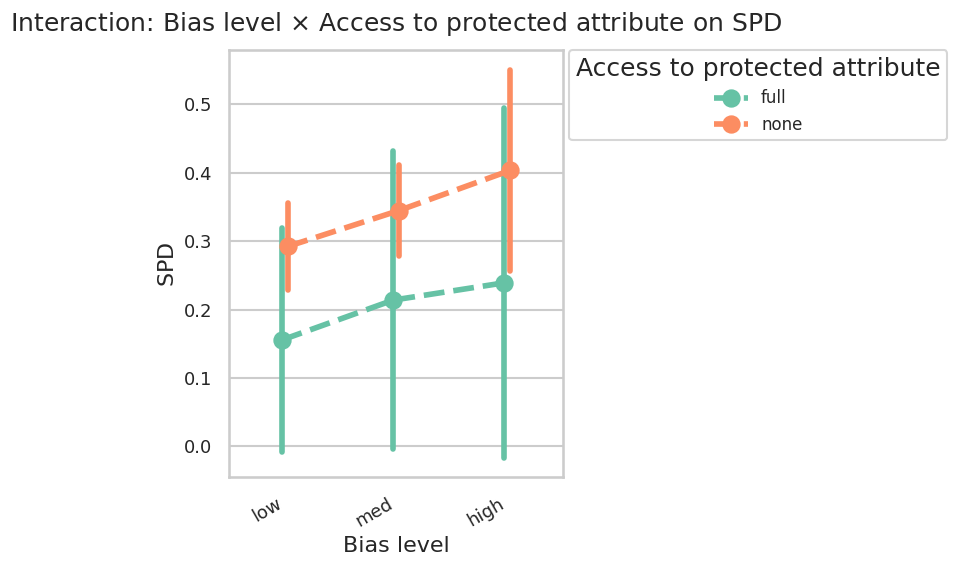

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


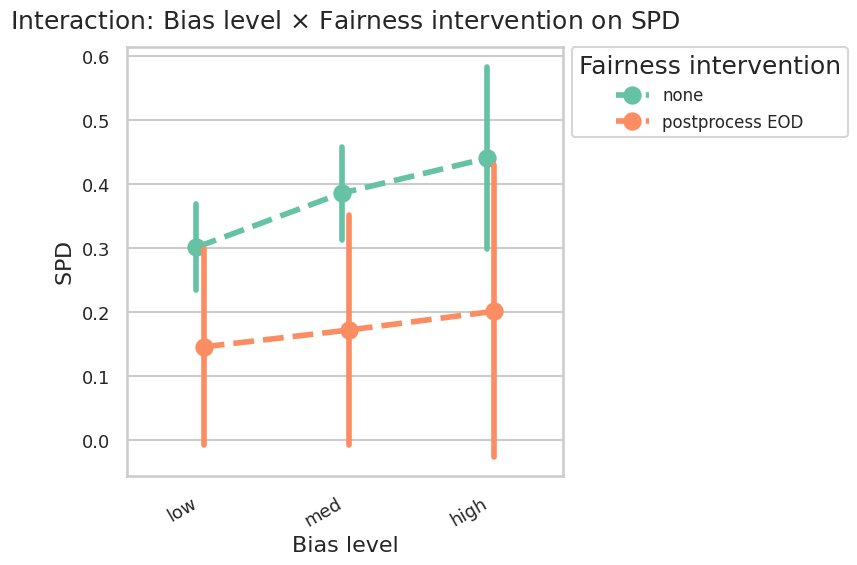

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


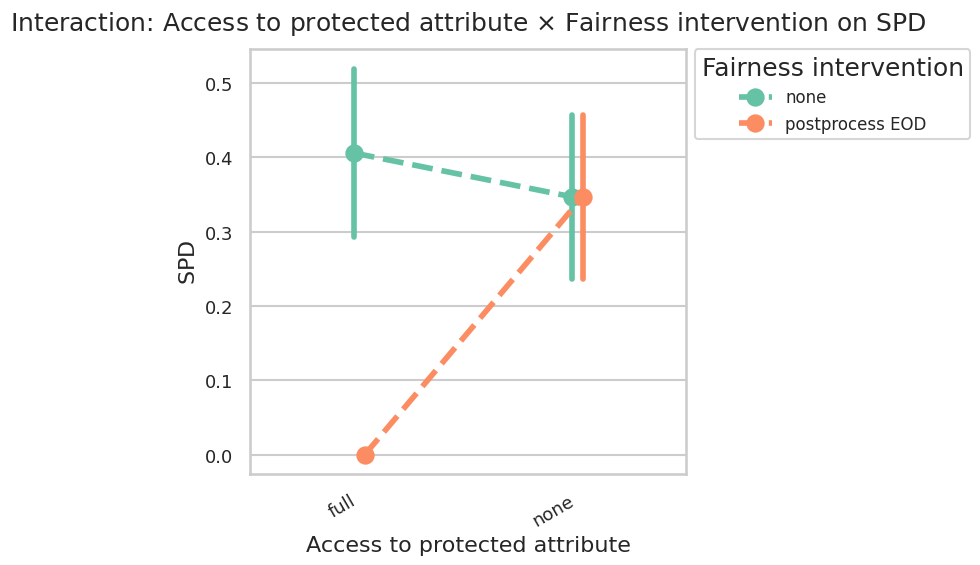

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


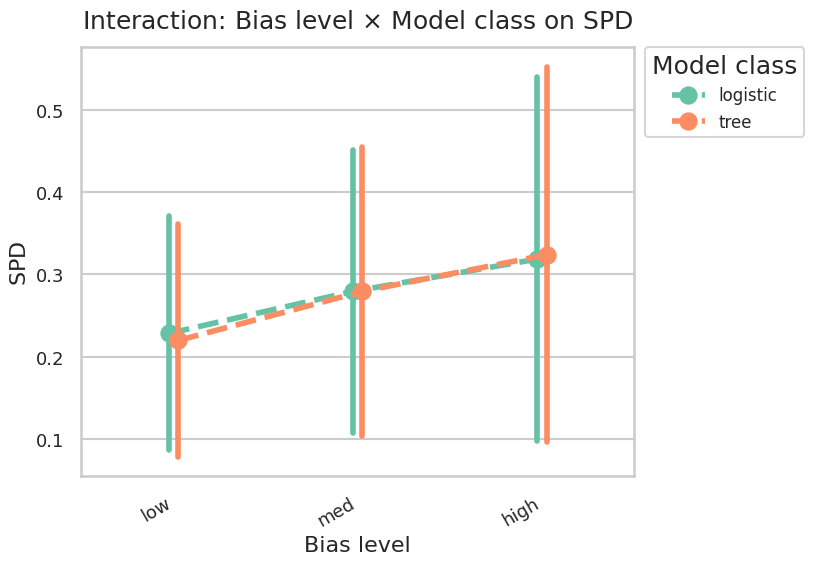

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


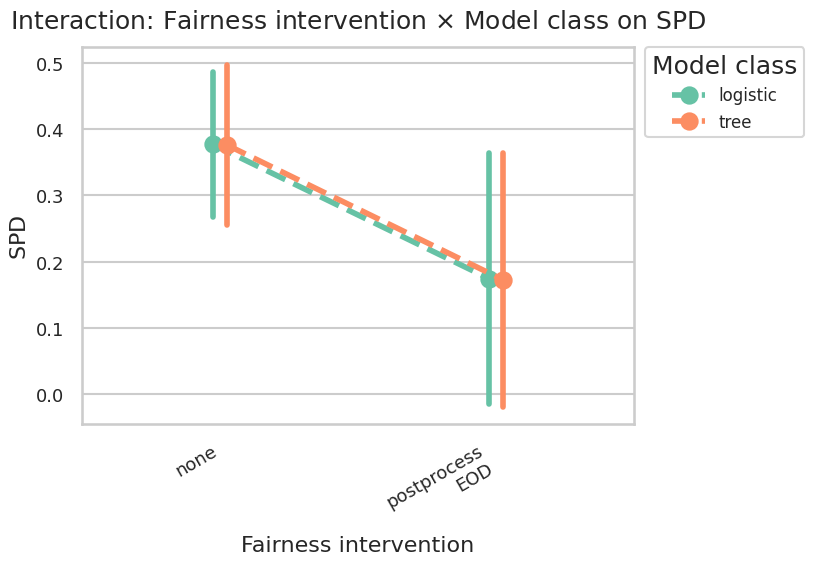

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


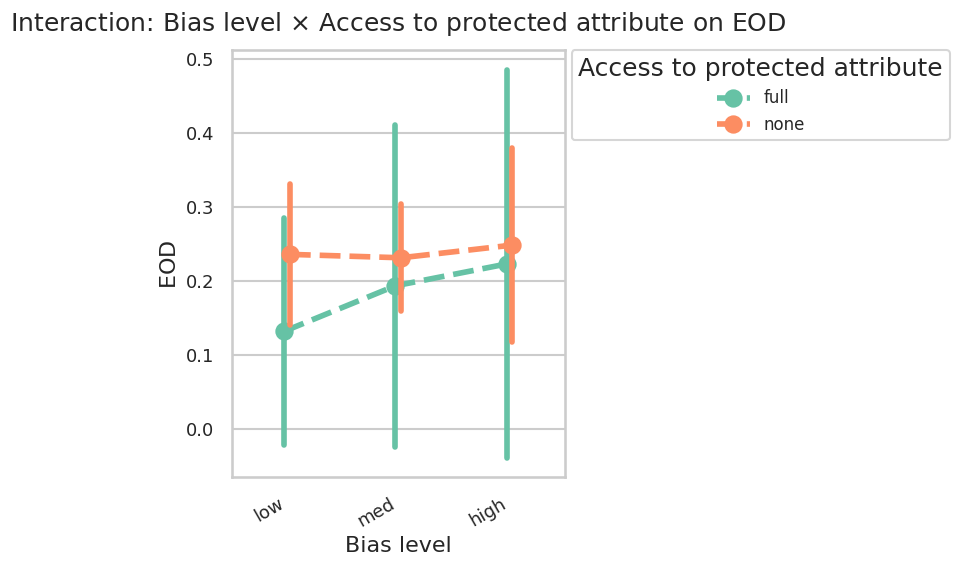

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


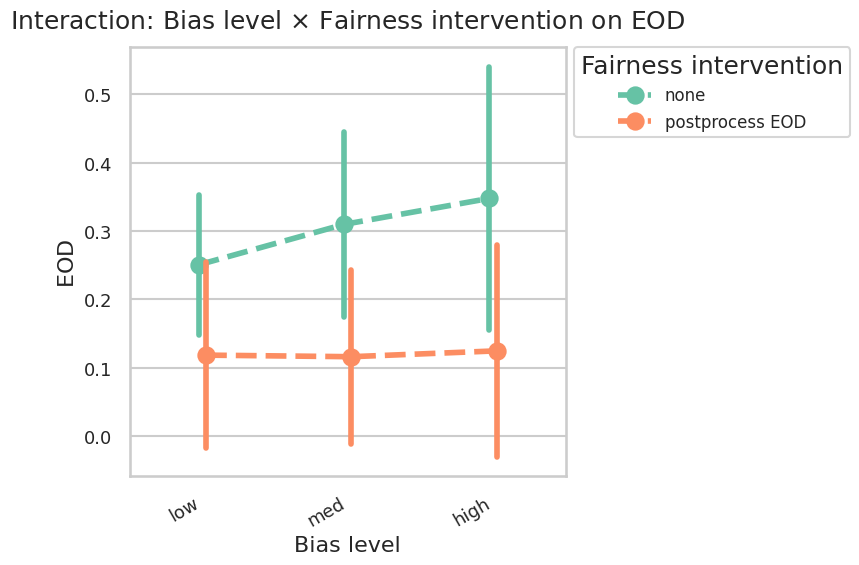

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


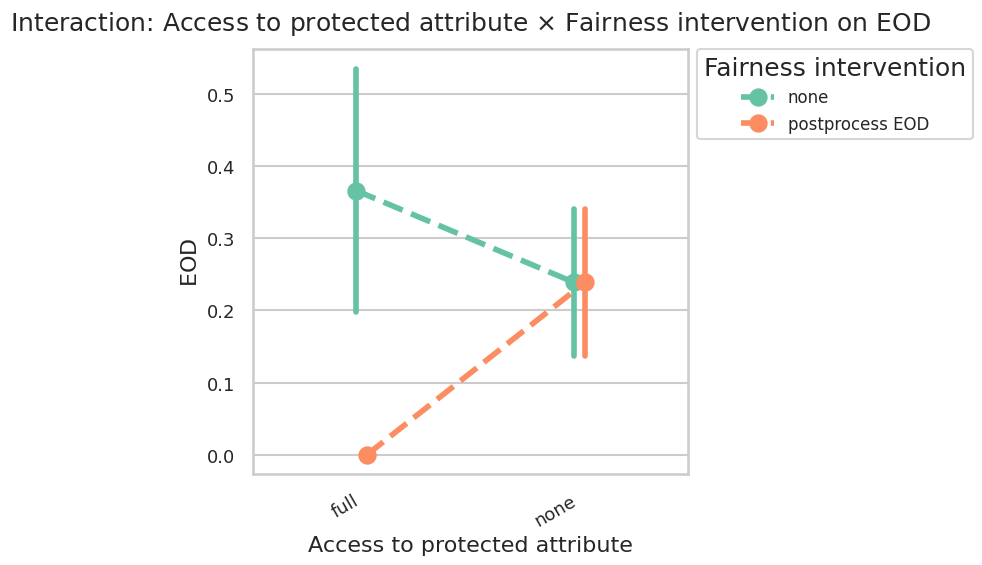

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


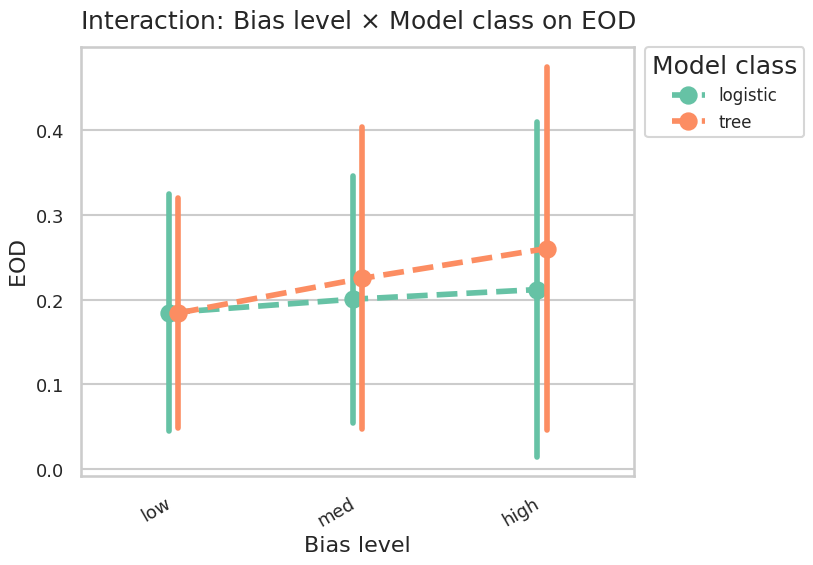

/tmp/ipython-input-4227386274.py:155: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(
/tmp/ipython-input-4227386274.py:155: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.pointplot(
/tmp/ipython-input-4227386274.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")


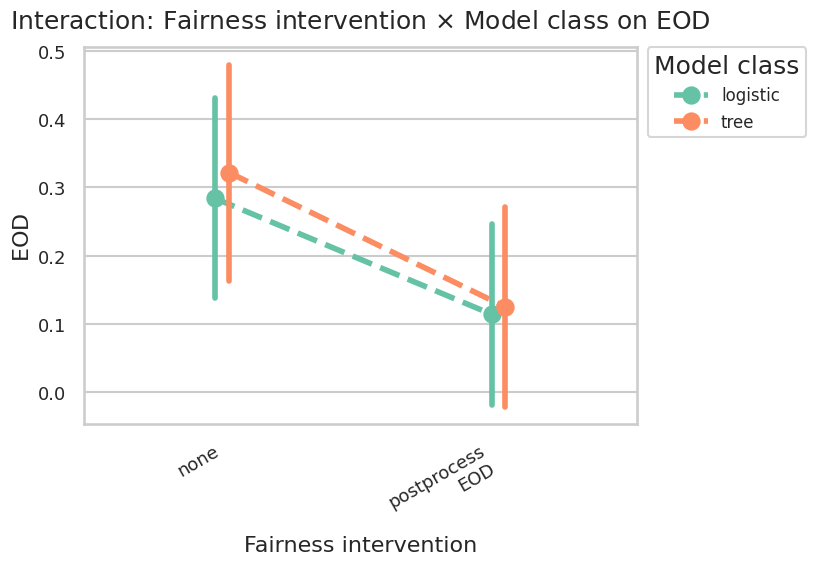

Saved captions table to: figs/figure_captions.csv


In [4]:
# ==================================================================================================
# FAIRNESS SIMULATION VISUALIZATION SCRIPT
# --------------------------------------------------------------------------------------------------
# Purpose:
#   Generates figures for main effects and two-way interactions.
# Input:
#   Assumes a DataFrame `df` containing the following columns:
#   [family, bias, access, intervention, model, replicate, accuracy, spd, eod]
#
# Output:
#   Saves vector graphics (PDF/SVG) for main effects and selected two-way interactions,

# ==================================================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import os

# ==============================================================================================
# 1. GLOBAL STYLE & CONFIGURATION
# ----------------------------------------------------------------------------------------------
# Sets consistent visual style, font sizes, color palette, and saving options.
# ==============================================================================================

sns.set(style="whitegrid", context="talk")

# Font sizes
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 12,
})

# Color palettes
MAIN_COLOR = "tab:blue"
INTERACTION_PALETTE = sns.color_palette("Set2")

# Figure saving settings
SAVE_FIGS = True
FIGDIR = "figs"

VECTOR_FORMATS = ["pdf", "svg"]

if SAVE_FIGS and not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR, exist_ok=True)


captions = []

# Helper function to wrap long x-axis labels for readability
def format_xticks(ax, width=12, rotation=30):
    labels = [textwrap.fill(lbl.get_text(), width) for lbl in ax.get_xticklabels()]
    _ = ax.set_xticklabels(labels, rotation=rotation, ha="right")

# ==============================================================================================
# 2. METRIC & FACTOR LABELING
# ==============================================================================================

metrics = ["accuracy", "spd", "eod"]
factors = ["family", "bias", "access", "intervention", "model"]

METRIC_LABEL = {
    "accuracy":  r"$\mathrm{Accuracy}$",
    "spd":       r"$\mathrm{SPD}$",
    "eod":       r"$\mathrm{EOD}$",
    "tpr_gap":   r"$\mathrm{TPR\ Gap}$",
    "fpr_gap":   r"$\mathrm{FPR\ Gap}$",
}

FACTOR_LABEL = {
    "family": "Data-generating family",
    "bias": "Bias level",
    "access": "Access to protected attribute",
    "intervention": "Fairness intervention",
    "model": "Model class",
}

# ==============================================================================================
# 3. MAIN EFFECT PLOTS
# ----------------------------------------------------------------------------------------------
# Plots the marginal effect of each factor on each fairness metric.
# ==============================================================================================

for metric in metrics:
    for factor in factors:
        fig, ax = plt.subplots(figsize=(7.5, 5.5))
        sns.pointplot(
            data=df,
            x=factor,
            y=metric,
            ci="sd",
            dodge=True,
            markers="o",
            linestyles="--",
            color=MAIN_COLOR,
            ax=ax,
        )

        format_xticks(ax, width=12, rotation=30)
        metric_label = METRIC_LABEL.get(metric, metric.upper())
        factor_label = FACTOR_LABEL.get(factor, factor)

        title = f"Main effect of {factor_label} on {metric_label}"
        ax.set_title(title, pad=14)
        ax.set_ylabel(metric_label)
        ax.set_xlabel(factor_label)

        plt.tight_layout()

        if SAVE_FIGS:
            base_name = f"main_{factor}_{metric}"
            for fmt in VECTOR_FORMATS:
                fname = os.path.join(FIGDIR, f"{base_name}.{fmt}")
                plt.savefig(fname, bbox_inches="tight")

            caption_text = (
                f"Main effect of {factor_label} on {metric_label}. "
                f"Points show the mean {metric_label} across simulation replicates "
                f"for each level of {factor_label}, and vertical bars represent one "
                f"standard deviation (±1 SD). The dashed line connects category means "
                f"to facilitate visual comparison across {factor_label} levels."
            )

            captions.append({
                "figure_id": base_name,
                "filename": base_name,
                "metric": metric,
                "factor_or_interaction": factor,
                "caption": caption_text,
            })

        plt.show()

# ==============================================================================================
# 4. TWO-WAY INTERACTION PLOTS
# ----------------------------------------------------------------------------------------------
# Visualizes interaction effects between key pairs of factors on fairness metrics.
# ==============================================================================================

two_way_interactions = [
    ("bias", "access"),
    ("bias", "intervention"),
    ("access", "intervention"),
    ("bias", "model"),
    ("intervention", "model"),
]

for metric in metrics:
    for (xvar, huevar) in two_way_interactions:
        fig, ax = plt.subplots(figsize=(8.5, 6.0))
        sns.pointplot(
            data=df,
            x=xvar,
            y=metric,
            hue=huevar,
            ci="sd",
            dodge=True,
            markers="o",
            linestyles="--",
            palette=INTERACTION_PALETTE,
            ax=ax,
        )

        format_xticks(ax, width=12, rotation=30)

        metric_label = METRIC_LABEL.get(metric, metric.upper())
        x_label = FACTOR_LABEL.get(xvar, xvar)
        hue_label = FACTOR_LABEL.get(huevar, huevar)

        title = f"Interaction: {x_label} × {hue_label} on {metric_label}"
        ax.set_title(title, pad=14)
        ax.set_ylabel(metric_label)
        ax.set_xlabel(x_label)

        ax.legend(
            title=hue_label,
            bbox_to_anchor=(1.02, 1),
            loc="upper left",
            borderaxespad=0.0,
        )

        plt.tight_layout()

        if SAVE_FIGS:
            base_name = f"interaction_{xvar}_{huevar}_{metric}"
            for fmt in VECTOR_FORMATS:
                fname = os.path.join(FIGDIR, f"{base_name}.{fmt}")
                plt.savefig(fname, bbox_inches="tight")

            caption_text = (
                f"Interaction between {x_label} and {hue_label} on {metric_label}. "
                f"Points show the mean {metric_label} across simulation replicates "
                f"for each combination of {x_label} (x-axis) and {hue_label} (line color), "
                f"and vertical bars represent one standard deviation (±1 SD). "
                f"Lines connect mean values within each level of {hue_label}, "
                f"illustrating how the effect of {x_label} varies across levels of "
                f"{hue_label}."
            )

            captions.append({
                "figure_id": base_name,
                "filename": base_name,
                "metric": metric,
                "factor_or_interaction": f"{xvar}×{huevar}",
                "caption": caption_text,
            })

        plt.show()

# ==============================================================================================
# 5. SAVE CAPTIONS TABLE
# ----------------------------------------------------------------------------------------------
# Creates a CSV file with figure IDs and self-contained captions.
# ==============================================================================================

if SAVE_FIGS and len(captions) > 0:
    captions_df = pd.DataFrame(captions)
    captions_path = os.path.join(FIGDIR, "figure_captions.csv")
    captions_df.to_csv(captions_path, index=False)
    print(f"Saved captions table to: {captions_path}")


In [ ]:
import os
from google.colab import files

# 1. Zip the figs folder
!zip -r figs.zip figs

# 2. Download the zip file
files.download('figs.zip')


updating: figs/ (stored 0%)
updating: figs/main_model_spd.pdf (deflated 32%)
updating: figs/main_bias_spd.pdf (deflated 32%)
updating: figs/interaction_intervention_model_spd.pdf (deflated 33%)
updating: figs/main_access_accuracy.pdf (deflated 32%)
updating: figs/interaction_intervention_model_eod.pdf (deflated 34%)
updating: figs/main_intervention_accuracy.svg (deflated 76%)
updating: figs/main_family_eod.svg (deflated 78%)
updating: figs/interaction_bias_model_accuracy.svg (deflated 79%)
updating: figs/interaction_intervention_model_eod.svg (deflated 78%)
updating: figs/interaction_intervention_model_accuracy.svg (deflated 79%)
updating: figs/interaction_access_intervention_eod.svg (deflated 80%)
updating: figs/main_model_accuracy.pdf (deflated 33%)
updating: figs/main_bias_eod.svg (deflated 75%)
updating: figs/interaction_bias_model_eod.pdf (deflated 33%)
updating: figs/interaction_bias_access_spd.svg (deflated 78%)
updating: figs/main_access_eod.pdf (deflated 33%)
updating: figs/in

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import pandas as pd

# ==============================================================================================
# AGGREGATED TABLES (Accuracy, SPD, EOD)
# ----------------------------------------------------------------------------------------------
# Builds wide tables with mean/std by (family, bias, access) and columns per intervention.
# ==============================================================================================

def make_metric_table(df, metric, index=("family","bias","access"), col="intervention"):
    """
    Create a wide table with mean/std of `metric`, grouped by `index`, with `col` as columns.
    Returns a tidy DataFrame sorted by index.
    """
    stats = (
        df
        .groupby(list(index) + [col], as_index=False)[[metric]]
        .agg(["mean", "std"])
    )

    wide = stats.pivot(index=list(index), columns=col)

    wide.columns = [
        f"{interv}__{metric}_{stat}"
        for (metric, stat, interv) in wide.columns.to_flat_index()
    ]

    return wide.reset_index().sort_values(list(index))


acc_table = make_metric_table(df, "accuracy")
spd_table = make_metric_table(df, "spd")
eod_table = make_metric_table(df, "eod")

print("acc_table:", acc_table.shape)
print("spd_table:", spd_table.shape)
print("eod_table:", eod_table.shape)

display(acc_table.head())
display(spd_table.head())
display(eod_table.head())

acc_table: (18, 7)
spd_table: (18, 7)
eod_table: (18, 7)


,family,bias,access,none__accuracy_mean,postprocess EOD__accuracy_mean,none__accuracy_std,postprocess EOD__accuracy_std
0,linear,high,full,0.828733,0.709467,0.011945,0.017156
1,linear,high,none,0.808333,0.808333,0.018449,0.018449
2,linear,low,full,0.780467,0.647333,0.015080,0.018878
3,linear,low,none,0.779533,0.779533,0.015369,0.015369
4,linear,med,full,0.807867,0.684133,0.012394,0.018112


,family,bias,access,none__spd_mean,postprocess EOD__spd_mean,none__spd_std,postprocess EOD__spd_std
0,linear,high,full,0.462165,0.000000,0.045013,0.000000
1,linear,high,none,0.285105,0.285105,0.027715,0.027715
2,linear,low,full,0.353074,0.000000,0.038673,0.000000
3,linear,low,none,0.326584,0.326584,0.029535,0.029535
4,linear,med,full,0.433741,0.000000,0.043104,0.000000


,family,bias,access,none__eod_mean,postprocess EOD__eod_mean,none__eod_std,postprocess EOD__eod_std
0,linear,high,full,0.591832,0.000000,0.107007,0.000000
1,linear,high,none,0.185145,0.185145,0.085413,0.085413
2,linear,low,full,0.333900,0.000000,0.095301,0.000000
3,linear,low,none,0.289465,0.289465,0.078649,0.078649
4,linear,med,full,0.482926,0.000000,0.114157,0.000000


In [8]:
import os

# ==============================================================================================
# SAVE RESULTS (CSV)
# ----------------------------------------------------------------------------------------------
# - Saves each table to CSV
# ==============================================================================================

def in_colab():
    """Return True if running inside Google Colab."""
    try:
        import google.colab
        return True
    except Exception:
        return False

def save_csv(df_obj, filename, do_download=None):
    """
    Save a DataFrame to CSV and optionally download in Colab.

    Parameters
    ----------
    df_obj : pd.DataFrame
        DataFrame to save.
    filename : str
        Output CSV filename (e.g., 'results.csv').
    do_download : bool or None
        - True: force download (if in Colab).
        - False: never download.
        - None: auto (download only if in Colab).
    """
    df_obj.to_csv(filename, index=False)
    print(f"Saved {filename} with shape: {df_obj.shape}")

    if do_download is None:
        do_download = in_colab()

    if do_download:
        try:
            from google.colab import files
            files.download(filename)
        except Exception as e:
            print(f"(Download skipped; not in Colab or failed) Reason: {e}")

save_csv(df, "results.csv")
save_csv(acc_table, "acc_table.csv")
save_csv(spd_table, "spd_table.csv")
save_csv(eod_table, "eod_table.csv")

Saved results.csv with shape: (720, 15)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved acc_table.csv with shape: (18, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved spd_table.csv with shape: (18, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved eod_table.csv with shape: (18, 7)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>